In [49]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [50]:
# Importing train and test data
train_data = pd.read_excel("Data_Train.xlsx")
test_data = pd.read_excel("Data_Test.xlsx")

print(train_data.shape)
print(test_data.shape)

(6019, 13)
(1234, 12)


In [51]:
# Printing First Five records of training data
train_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


<b>Feature Description 

Name : The brand and model of the car.

Location: The location in which the car is being sold or is available for purchase. 

Year: The year or edition of the model.

Kilometers_Driven: The total kilometres driven in the car by the previous owner(s) in KM. 

Fuel_Type: The type of fuel used by the car. 

Transmission: The type of transmission used by the car. 

Owner_Type: Whether the ownership is Firsthand, Second hand or other. 

Mileage: The standard mileage offered by the car company in kmpl or km/kg 

Engine: The displacement volume of the engine in cc. 

Power: The maximum power of the engine in bhp. 

Seats: The number of seats in the car. 

New_Price: The price of a new car of the same model. 

Price: The price of the used car in INR Lakhs.</b>

In [52]:
# Looking for null values in training set
null_values =train_data.isnull().sum()
pd.DataFrame({
    "Null_Values" : null_values,
    "Null_Values_Percentage" : np.round(100*(null_values/len(train_data)),2)
}).sort_values(by="Null_Values", ascending=False).head(5)

,Null_Values,Null_Values_Percentage
New_Price,5195,86.31
Seats,42,0.70
Engine,36,0.60
Power,36,0.60
Mileage,2,0.03


In [53]:
# Looking for null values in test set
null_values =test_data.isnull().sum()
pd.DataFrame({
    "Null_Values" : null_values,
    "Null_Values_Percentage" : np.round(100*(null_values/len(test_data)),2)
}).sort_values(by="Null_Values", ascending=False).head(4)

,Null_Values,Null_Values_Percentage
New_Price,1052,85.25
Seats,11,0.89
Engine,10,0.81
Power,10,0.81


In [54]:
# Concatinating both train and test data
train_data["is_train"] = True
test_data["is_train"] = False
test_data["Price"] = np.nan

combine_data =  pd.concat([train_data, test_data], axis=0,sort=False )
print(combine_data.shape)

(7253, 14)


### NAME

In [55]:
#  Getting Car Company Name
combine_data["Car_Name_1"] = combine_data["Name"].apply(lambda x  : x.split()[0])
combine_data["Car_Name_1"] = combine_data["Car_Name_1"].str.upper()
# Getting Car Compnay Name with car name
combine_data["Car_Name_2"] = combine_data["Name"].apply(lambda x : " ".join(x.split()[0:2]))
combine_data["Car_Name_2"] = combine_data["Car_Name_2"].str.upper()

In [56]:
# Type of COlumns
numerical_columns = ['Year','Kilometers_Driven','Mileage','Engine', 'Power', 'Seats','New_Price']
categorical_columns = ['Car_Name_1','Location','Fuel_Type','Transmission']
ordinal_column = ['Owner_Type']
target_column = ["Price"]

In [57]:
# Getting unique values of each columns
for i in np.arange(len(categorical_columns)):
    print("Unique Values in column {} is {}".format(categorical_columns[i], sorted(combine_data[categorical_columns[i]].unique())))
    print("\n")
for i in np.arange(len(ordinal_column)):
    print("Unique Values in column {} is {}".format(ordinal_column[i], sorted(combine_data[ordinal_column[i]].unique())))
    print("\n")

Unique Values in column Car_Name_1 is ['AMBASSADOR', 'AUDI', 'BENTLEY', 'BMW', 'CHEVROLET', 'DATSUN', 'FIAT', 'FORCE', 'FORD', 'HINDUSTAN', 'HONDA', 'HYUNDAI', 'ISUZU', 'JAGUAR', 'JEEP', 'LAMBORGHINI', 'LAND', 'MAHINDRA', 'MARUTI', 'MERCEDES-BENZ', 'MINI', 'MITSUBISHI', 'NISSAN', 'OPELCORSA', 'PORSCHE', 'RENAULT', 'SKODA', 'SMART', 'TATA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO']


Unique Values in column Location is ['Ahmedabad', 'Bangalore', 'Chennai', 'Coimbatore', 'Delhi', 'Hyderabad', 'Jaipur', 'Kochi', 'Kolkata', 'Mumbai', 'Pune']


Unique Values in column Fuel_Type is ['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol']


Unique Values in column Transmission is ['Automatic', 'Manual']


Unique Values in column Owner_Type is ['First', 'Fourth & Above', 'Second', 'Third']




In [58]:
# Fill NA in New_Price Column
def price_convert(x):
    if x.split()[1] == "Lakh":
        x = float(x.replace(" Lakh",""))
        x = np.round(x *100000)
    elif x.split()[1] == "Cr":
        x = float(x.replace(" Cr",""))
        x = np.round(x *10000000)
    elif x.split()[1] == "unknown":
        x = float(x.replace("unknown unknown","0"))
    return x

combine_data["New_Price"].fillna("unknown unknown", inplace = True)
combine_data["New_Price"] = combine_data["New_Price"].apply(lambda x : price_convert(x))
combine_data["New_Price"] = combine_data["New_Price"].astype("int")
combine_data["New_Price"].replace({0:np.nan}, inplace= True)

# Fill null Values in New_Price of car according to the Median New_Price of that car Name
dict_1 = dict(combine_data.groupby("Car_Name_2")["New_Price"].median())
combine_data["New_Price"] = combine_data["New_Price"].fillna(value = combine_data["Car_Name_2"].apply(lambda x :dict_1.get(x)))

dict_2 = dict(combine_data.groupby("Car_Name_1")["New_Price"].median())
combine_data["New_Price"] = combine_data["New_Price"].fillna(value = combine_data["Car_Name_1"].apply(lambda x :dict_2.get(x)))

combine_data["New_Price"].fillna(combine_data["New_Price"].median(), inplace=True)
combine_data["New_Price"].isnull().sum()

0

In [59]:
# FIll Null Value in Seats Column according to the Car Name
combine_data["Seats"].replace({0:np.nan}, inplace = True)
dict_3 = dict(combine_data.groupby("Car_Name_2")["Seats"].median())
combine_data["Seats"] = combine_data["Seats"].fillna(value= combine_data["Car_Name_2"].apply(lambda x : dict_3.get(x)))

dict_4 = dict(combine_data.groupby(by =["Car_Name_1"])["Seats"].median())
combine_data["Seats"] = combine_data["Seats"].fillna(value=combine_data["Car_Name_1"].apply(lambda x : dict_4.get(x)))
print(combine_data["Seats"].isnull().sum())

0


In [60]:
# Replacing string in numerial columns with blank
combine_data["Engine"].replace({np.nan:"0"}, inplace= True)
combine_data["Engine"] = combine_data["Engine"].apply(lambda x :float(x.replace("CC","")))
combine_data["Engine"].replace({0: np.nan}, inplace= True)

combine_data["Power"].replace({np.nan:"0","null bhp":"0"}, inplace= True)
combine_data["Power"] = combine_data["Power"].apply(lambda x :float(x.replace("bhp","")))
combine_data["Power"].replace({0: np.nan}, inplace=True)

combine_data["Mileage"].replace({np.nan:"0"}, inplace= True) # This will find the whole word and replace the whole word
combine_data["Mileage"] = combine_data["Mileage"].str.replace('kmpl','km/kg') # .str works for whole column at once and will replace any word out of text line
combine_data["Mileage"] = combine_data["Mileage"].apply(lambda x :float(x.replace("km/kg",""))) # without .str will replace one by one line
combine_data["Mileage"].replace({0: np.nan}, inplace=True)

In [61]:
# Fill NA in MIleage column as per the median value of Mileage group by car name
dict_5 = dict(combine_data.groupby("Car_Name_2")["Mileage"].median())
combine_data["Mileage"] = combine_data["Mileage"].fillna(value= combine_data["Car_Name_2"].apply(lambda x : dict_5.get(x)))

dict_6 = dict(combine_data.groupby(by =["Car_Name_1"])["Mileage"].median())
combine_data["Mileage"] = combine_data["Mileage"].fillna(value=combine_data["Car_Name_1"].apply(lambda x : dict_6.get(x)))
print(combine_data["Mileage"].isnull().sum())

1


In [62]:
combine_data[combine_data["Mileage"].isnull() == True]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,is_train,Car_Name_1,Car_Name_2
915,Smart Fortwo CDI AT,Pune,2008,103000,Diesel,Automatic,Second,NaN,799.0,NaN,2.0,1131500.0,3.0,True,SMART,SMART FORTWO


Here we do not have any record of SMART FORTWO car. So I will replace this one record according to the Engine Value of 799.

In [63]:
dict_11 = dict(combine_data.groupby("Engine")["Mileage"].median())
combine_data["Mileage"] = combine_data["Mileage"].fillna(value= combine_data["Engine"].apply(lambda x : dict_11.get(x)))

In [64]:
# Fill NA in Engine column as per the median value of Engine group by car name
dict_7 = dict(combine_data.groupby("Car_Name_2")["Engine"].median())
combine_data["Engine"] = combine_data["Engine"].fillna(value= combine_data["Car_Name_2"].apply(lambda x : dict_7.get(x)))

dict_8 = dict(combine_data.groupby(by =["Car_Name_1"])["Engine"].median())
combine_data["Engine"] = combine_data["Engine"].fillna(value=combine_data["Car_Name_1"].apply(lambda x : dict_8.get(x)))
print(combine_data["Engine"].isnull().sum())

0


In [65]:
# Fill NA in Power column as per the median value of Power group by car name
dict_9 = dict(combine_data.groupby("Car_Name_2")["Power"].median())
combine_data["Power"] = combine_data["Power"].fillna(value= combine_data["Car_Name_2"].apply(lambda x : dict_9.get(x)))

dict_10 = dict(combine_data.groupby(by =["Car_Name_1"])["Power"].median())
combine_data["Power"] = combine_data["Power"].fillna(value=combine_data["Car_Name_1"].apply(lambda x : dict_10.get(x)))
print(combine_data["Power"].isnull().sum())

2


In [66]:
combine_data[combine_data["Power"].isnull() == True]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,is_train,Car_Name_1,Car_Name_2
915,Smart Fortwo CDI AT,Pune,2008,103000,Diesel,Automatic,Second,25.17,799.0,NaN,2.0,1131500.0,3.0,True,SMART,SMART FORTWO
197,Hindustan Motors Contessa 2.0 DSL,Pune,1996,65000,Diesel,Manual,Second,14.10,1995.0,NaN,5.0,1131500.0,NaN,False,HINDUSTAN,HINDUSTAN MOTORS


As we do not have any other record of these two cars So here I am going to replace NA values in Power columns as per median value of Power according to Engine Value.

In [67]:
dict_12 = dict(combine_data.groupby("Engine")["Power"].median())
combine_data["Power"] = combine_data["Power"].fillna(value= combine_data["Engine"].apply(lambda x : dict_12.get(x)))

In [68]:
# Getting Age of the Vehicle according to the year
print("Max value of year given in the data :" ,combine_data["Year"].max())
print("Min value of Year given in the data :" ,combine_data["Year"].min())

combine_data["Age_of_Car"] = 2019 - combine_data["Year"]

Max value of year given in the data : 2019
Min value of Year given in the data : 1996


In [69]:
# Changiing order from text tvo numeric
combine_data["Owner_Type"].replace({'First':1,'Second':2,'Third':3,'Fourth & Above':4}, inplace = True)

In [70]:
# Adding New Features
combine_data["AVG_MILEAGE_AS_PER_FUEL_TYPE"] = combine_data.groupby("Fuel_Type")["Mileage"].transform("mean")
combine_data["KM_DRIVEN_PER_YEAR"] = combine_data["Kilometers_Driven"] / combine_data["Age_of_Car"]
combine_data["AVG_NEW_PRICE_AS_PER_CARNAME_FUEL"] = combine_data.groupby(["Car_Name_1","Fuel_Type"])["New_Price"].transform("mean")

In [71]:
combine_data.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Price', 'is_train', 'Car_Name_1', 'Car_Name_2',
       'Age_of_Car', 'AVG_MILEAGE_AS_PER_FUEL_TYPE', 'KM_DRIVEN_PER_YEAR',
       'AVG_NEW_PRICE_AS_PER_CARNAME_FUEL'],
      dtype='object')

In [72]:
# Separating Train and Test data from combine data
train_data =  combine_data[combine_data["is_train"]==True]
test_data = combine_data[combine_data["is_train"] == False]
train_data.drop(labels = ["is_train"], axis=1, inplace = True)
test_data.drop(labels = ["is_train","Price"], axis=1, inplace = True)

print(train_data.shape)
print(test_data.shape)

(6019, 19)
(1234, 18)


C:\Users\babit\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Exploratory Data Analysis

### Univariate Analysis - Numerical Columns

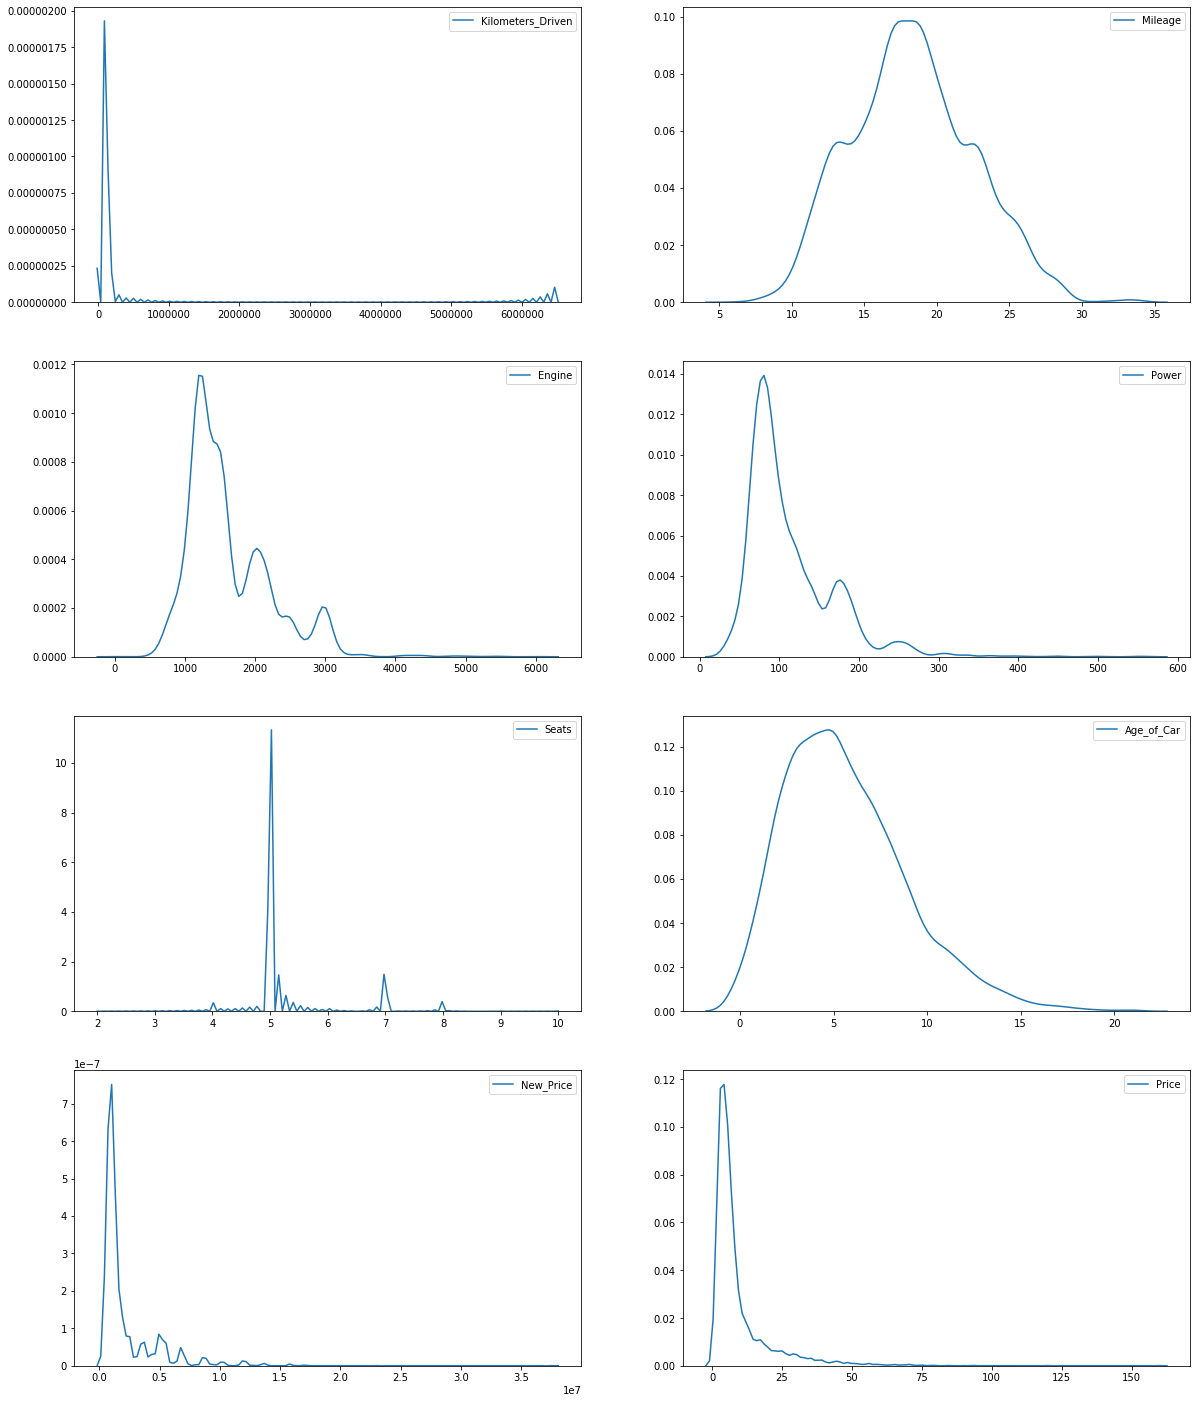

In [73]:
# Kdeplot
num_cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats','Age_of_Car','New_Price', 'Price']
fig, axes = plt.subplots(4,2 , figsize = (20,25))
k = 0
for i in np.arange(4):
    for j in np.arange(2):
        sns.kdeplot(train_data[num_cols[k]] , ax=axes[i][j])
        k += 1
plt.show()

Data is normally distributed for some of the columns like mileage, age_of_car but for other columns like price, new_price, engine data is rightly skewed distributed.

### Bi-Variate Analysis

Correlation Value between Power and Engine : 0.87


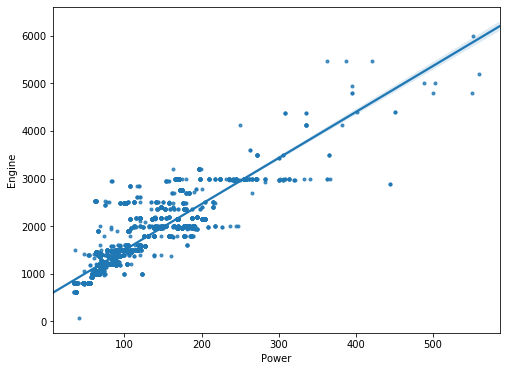

In [74]:
# Engine VS Power
print("Correlation Value between Power and Engine :",np.round(train_data["Power"].corr(train_data["Engine"]),2))
plt.figure(figsize = (8,6))
_ = sns.regplot(x=train_data["Power"] , y=train_data["Engine"], marker='.')

Correlation Value between Mileage and Engine : -0.64


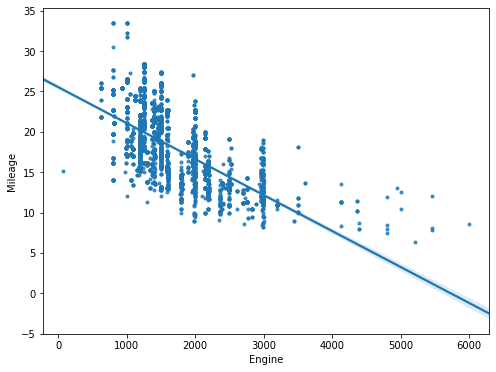

In [75]:
# Engine VS Mileage
print("Correlation Value between Mileage and Engine :",np.round(train_data["Mileage"].corr(train_data["Engine"]),2))
plt.figure(figsize = (8,6))
_ = sns.regplot(x=train_data["Engine"] , y=train_data["Mileage"], marker='.')

Correlation Value between Power and Mileage : -0.55


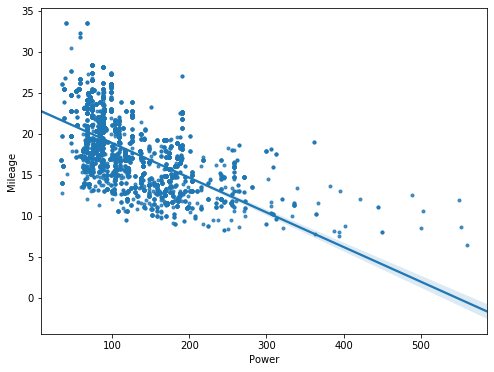

In [76]:
# Mileage VS Power
print("Correlation Value between Power and Mileage :",np.round(train_data["Power"].corr(train_data["Mileage"]),2))
plt.figure(figsize = (8,6))
_ = sns.regplot(x=train_data["Power"] , y=train_data["Mileage"], marker='.')

### Independent Numerical Columns with Target column

Correlation Value between Kilometers_Driven and Price : -0.011492790740116178
Correlation Value between Mileage and Price : -0.3346753826793943
Correlation Value between Engine and Price : 0.6589589507147633
Correlation Value between Power and Price : 0.7738374895765335
Correlation Value between Seats and Price : 0.053675804932744826
Correlation Value between Age_of_Car and Price : -0.3053274083613484
Correlation Value between New_Price and Price : 0.7633599191128673


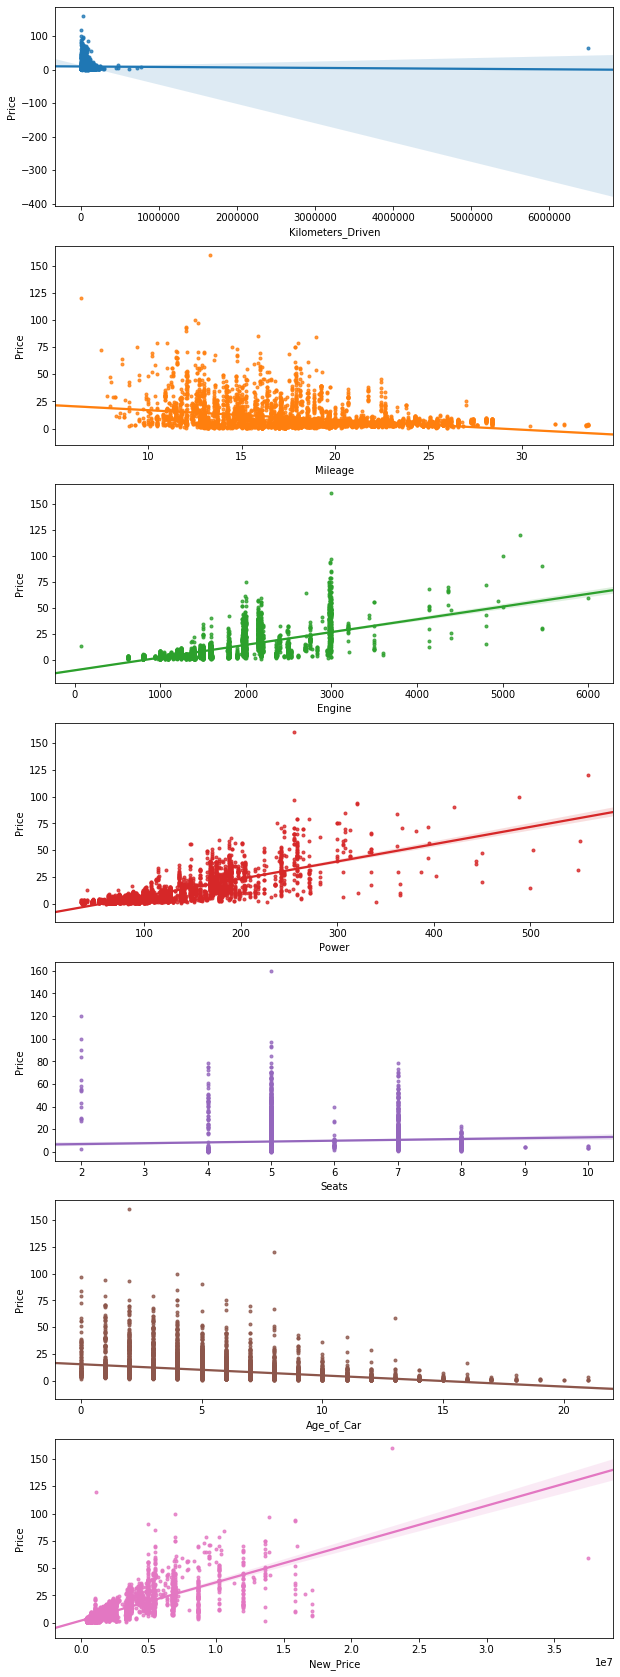

In [77]:
feature_num_cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats','Age_of_Car','New_Price']
fig, axes = plt.subplots(nrows=7,ncols=1, figsize = (10,30), squeeze= False)
for i in np.arange(len(feature_num_cols)):
    print("Correlation Value between {} and Price : {}".format(feature_num_cols[i] ,train_data[feature_num_cols[i]].corr(train_data["Price"])))
    sns.regplot(x=train_data[feature_num_cols[i]] , y=train_data["Price"], marker='.', ax=axes[i][0])

Kilometer driven has no effect on the Price of the used Car but engine and power of the car has high correlation value with the price of the car. New Price of the car also plays important role in deciding the price of old car.

### Categorical Colunms - Univariate Analysis

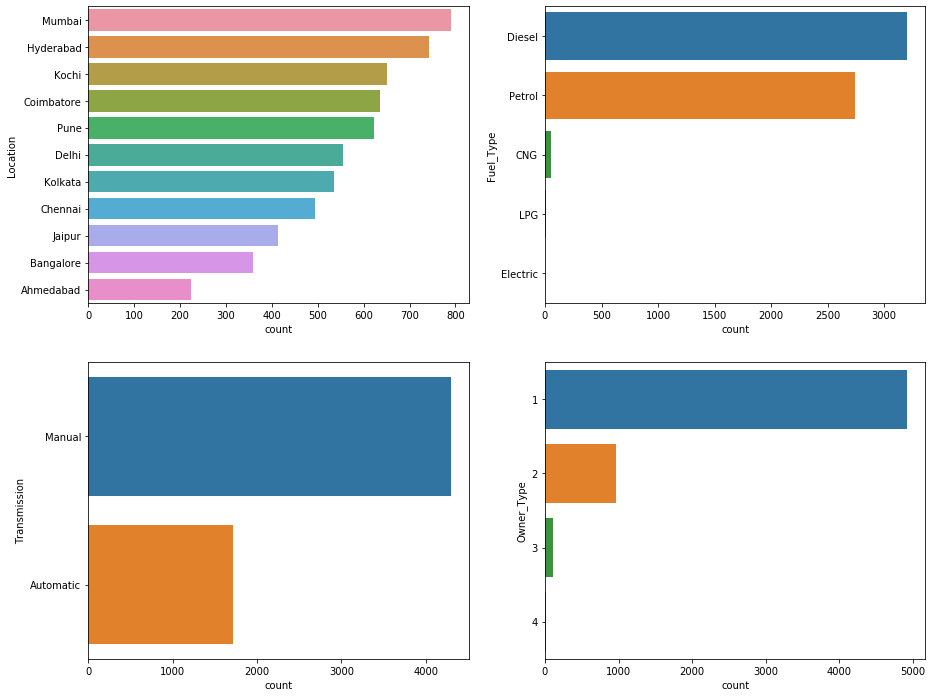

In [78]:
cat_cols = ['Location','Fuel_Type','Transmission', 'Owner_Type']
fig , ax = plt.subplots(2,2,figsize =(15,12))
k = 0
for i in np.arange(2):
    for j in np.arange(2):
        sns.countplot(y =train_data[cat_cols[k]], ax=ax[i][j], order=train_data[cat_cols[k]].value_counts().index)
        k += 1

Maximum Number of old cars for sale are from Mumbai followed by hyderabad.

Fuel Type of Most of the cars is Diesel.

Transmission Type of most of the cars is Manual

Owner Type of most of the cars is First

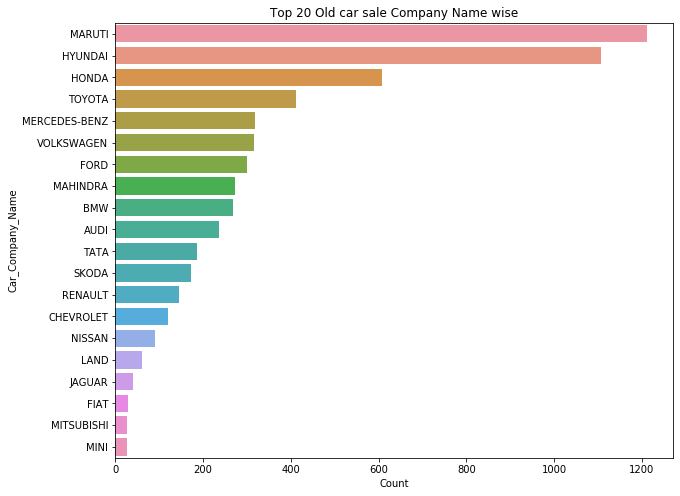

In [79]:
# Top 20 cars sold company name wise
plt.figure(figsize=(10,8))
top_20_cars = train_data["Car_Name_1"].value_counts().head(20).reset_index()
top_20_cars.columns =["Car_Company_Name","Count"]
top_20_cars
_ =sns.barplot(x=top_20_cars["Count"], y=top_20_cars["Car_Company_Name"])
plt.title("Top 20 Old car sale Company Name wise")
plt.show()

Text(0.5, 1.0, 'Top 20 old car sale Car Name Wise')

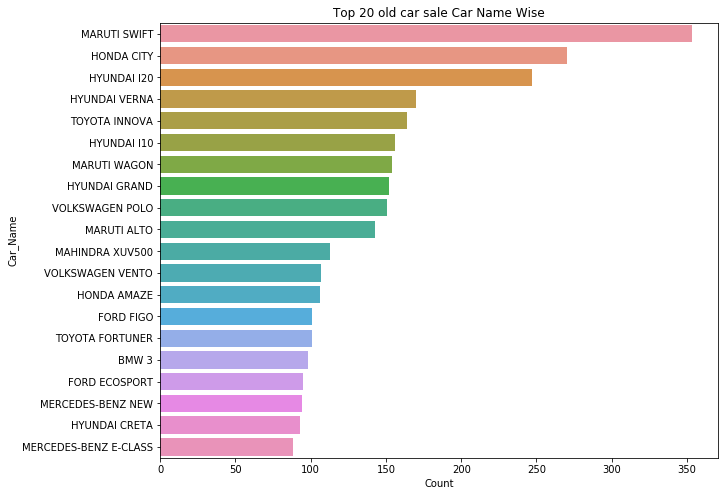

In [80]:
plt.figure(figsize=(10,8))
top_20_cars = train_data["Car_Name_2"].value_counts().head(20).reset_index()
top_20_cars.columns =["Car_Name","Count"]
top_20_cars
_ =sns.barplot(x=top_20_cars["Count"], y=top_20_cars["Car_Name"])
plt.title("Top 20 old car sale Car Name Wise")

In [81]:
# Getting number of Unique values in Car_Name_1 and Car_Name_2
print("Total Unique values in Car_Name_1 : {}".format(train_data["Car_Name_1"].nunique()))
print("Total Unique values in Car_Name_1 : {}".format(train_data["Car_Name_2"].nunique()))

Total Unique values in Car_Name_1 : 30
Total Unique values in Car_Name_1 : 215


In [82]:
train_data.drop(labels = ["Name","Car_Name_2","Year"], inplace=True, axis=1)
test_data.drop(labels = ["Name","Car_Name_2","Year"], inplace=True, axis=1)

C:\Users\babit\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [83]:
X_train = train_data.drop("Price", axis=1)
X_test = test_data
y_train = train_data["Price"]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(6019, 15)
(1234, 15)
(6019,)


## CAT BOOST

In [84]:
X_train = X_train.drop(labels = ["Kilometers_Driven","Seats"], axis=1)
X_test = X_test.drop(labels = ["Kilometers_Driven","Seats"], axis=1)

In [ ]:
cat_cols = ['Location','Fuel_Type','Transmission','Car_Name_1']
cat_boost = CatBoostRegressor(n_estimators=1500, learning_rate=1/20, random_state= 101,max_depth=9, cat_features=cat_cols)
cat_boost.fit(X_train, y_train)

y_pred_train = cat_boost.predict(X_train)
y_pred_test = cat_boost.predict(X_test)

In [86]:
print("Accuracy :",1 - np.sqrt(np.square(np.log10(y_pred_train +1) - np.log10(y_train +1)).mean()))

Accuracy : 0.9651199182585647


**Accuracy on Test data is 93.95%**

## Light GBM

In [88]:
# Label Encoder for Categorical columns
label_encoder = LabelEncoder()
X_train["is_train"] = "YES"
X_test["is_train"] = "NO"
combine_data = pd.concat([X_train, X_test] , axis=0,sort=False)

combine_data["Location"] = label_encoder.fit_transform(combine_data["Location"])
combine_data["Fuel_Type"] = label_encoder.fit_transform(combine_data["Fuel_Type"])
combine_data["Transmission"] = label_encoder.fit_transform(combine_data["Transmission"])
combine_data["Car_Name_1"] = label_encoder.fit_transform(combine_data["Car_Name_1"])

X_train =combine_data[combine_data["is_train"] =="YES"]
X_test = combine_data[combine_data["is_train"] == "NO"]

X_train.drop(labels = ["is_train"], inplace= True, axis = 1)
X_test.drop(labels = ["is_train"], inplace= True, axis = 1)

In [89]:
cat_cols = ['Location','Fuel_Type','Transmission','Car_Name_1']

lgbm_regressor = LGBMRegressor(boosting_type='gbdt',num_leaves=70, n_estimators=1500, max_depth=9, learning_rate=0.05,
                              random_state=101, colsample_bytree=0.75, categorical_features = cat_cols)
lgbm_regressor.fit(X_train, y_train)

y_pred_train = lgbm_regressor.predict(X_train)
y_pred_test = lgbm_regressor.predict(X_test)

print("Accuracy :",1 - np.sqrt(np.square(np.log10(y_pred_train +1) - np.log10(y_train +1)).mean()))

Accuracy : 0.9606890969507804


In [90]:
Sample_submission = pd.read_excel("Sample_submission.xlsx",index_col=False)
Sample_submission["Price"] = y_pred_test
Sample_submission.to_excel("Sample_submission.xlsx", index= False)

**Accuracy on the test set is 93.37%**